In [1]:
import numpy as np
import seaborn as sns
import pyspikelib.utils as spkutil
import pyspikelib.mpladeq as mpladeq

from pathlib import Path

sns.set(font_scale=1.7, style='ticks')
mpladeq.beautify_mpl()

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
np.random.seed(15)

In [4]:
! ls ../data/*

../data/fcx1_data.tar


In [5]:
! cd ../data; tar -xvf ../data/fcx1_data.tar ./

./README.md
./sleep.parq.gz
./wake.parq.gz


In [6]:
! gzip -df ../data/sleep.parq.gz; gzip -df ../data/wake.parq.gz 

In [7]:
datapath = Path('../data')

In [8]:
wake_data = spkutil.load_parquet(datapath / 'wake.parq')
sleep_data = spkutil.load_parquet(datapath / 'sleep.parq')

In [9]:
data = {}

data['wake_train'], data['wake_test'] = spkutil.split_by_spikes(wake_data, ratio=0.5)
data['sleep_train'], data['sleep_test'] = spkutil.split_by_spikes(sleep_data, ratio=0.5)

Text(0, 0.5, 'ISI value, ms')

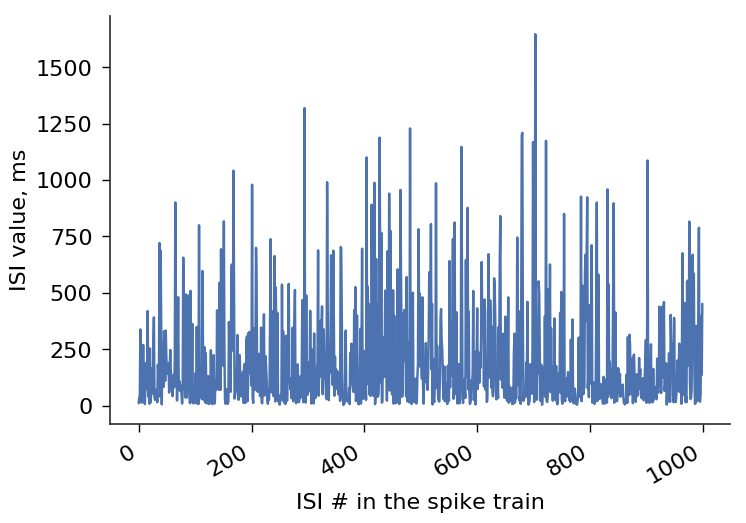

In [10]:
p.plot(data['wake_train']['series'][5][:1000])

mpladeq.prettify()
p.xlabel('ISI # in the spike train')
p.ylabel('ISI value, ms')

In [11]:
window_size = 100
step_size = 100
total_samples = 5000

crop_data = {}
for key in data:
    crop_data[key] = spkutil.crop_isi_samples(data[key],
                                              window_size=window_size,
                                              step_size=step_size,
                                              total_samples=total_samples)

In [12]:
[(key, crop_data[key]['series'].shape) for key in crop_data]

[('wake_train', (5000, 100)),
 ('wake_test', (5000, 100)),
 ('sleep_train', (5000, 100)),
 ('sleep_test', (5000, 100))]

In [13]:
tsdata = {}
for key in data:
    tsdata[key] = spkutil.tsfresh_vectorize(crop_data[key]['series'],
                                            feature_dict='distribution_features',
                                            n_jobs=24)

Feature Extraction: 100%|██████████| 120/120 [00:02<00:00, 44.34it/s]


In [14]:
tsdata['wake_train'].head(10)

variable,value__abs_energy,value__count_above_mean,value__count_below_mean,value__kurtosis,value__large_standard_deviation__r_0.05,value__large_standard_deviation__r_0.1,value__large_standard_deviation__r_0.15000000000000002,value__large_standard_deviation__r_0.2,value__large_standard_deviation__r_0.25,value__large_standard_deviation__r_0.30000000000000004,...,value__symmetry_looking__r_0.6000000000000001,value__symmetry_looking__r_0.65,value__symmetry_looking__r_0.7000000000000001,value__symmetry_looking__r_0.75,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9,value__symmetry_looking__r_0.9500000000000001,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,3.583048e+07,25.0,75.0,18.741613,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,272827.792265,1.0
1,5.633661e+05,33.0,67.0,5.554171,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2626.619093,1.0
2,1.154701e+06,31.0,69.0,6.126066,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6371.361036,1.0
3,8.913022e+05,32.0,68.0,13.832198,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4916.506776,1.0
4,8.073505e+06,34.0,66.0,3.357791,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,30647.486969,1.0
5,8.512015e+05,34.0,66.0,5.330912,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3911.987523,1.0
6,1.158157e+08,32.0,68.0,6.455682,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,688772.907244,1.0
7,1.019945e+06,31.0,69.0,49.016426,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6200.535581,1.0
8,1.447338e+06,28.0,72.0,7.877762,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,7489.601589,1.0


In [15]:
samples = 4500
indices = np.random.choice(total_samples, samples)

X_train = pd.concat([tsdata['wake_train'].iloc[indices, :], tsdata['sleep_train'].iloc[indices, :]])
y_train = np.array([0] * indices.shape[0] + [1] * indices.shape[0])

X_test = pd.concat([tsdata['wake_test'].iloc[indices, :], tsdata['sleep_test'].iloc[indices, :]])
y_test = np.array([0] * indices.shape[0] + [1] * indices.shape[0])

In [16]:
X_train, scaler = spkutil.preprocess_tsfresh_features(X_train,
                                                      remove_low_variance=True)

X_test, _ = spkutil.preprocess_tsfresh_features(X_test,
                                                scaler=scaler,
                                                remove_low_variance=True)

X_train, X_test = spkutil.train_test_common_features(X_train, X_test)

In [17]:
forest = RandomForestClassifier(n_estimators=200,
                                random_state=42,
                                n_jobs=-1)


forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [18]:
accuracy_score(y_test, forest.predict(X_test))

0.7293333333333333

In [19]:
importance = pd.DataFrame()
importance['feature'] = X_train.columns.values
importance['importance_score'] = forest.feature_importances_

In [20]:
importance.sort_values(by='importance_score', ascending=False).head(20)

,feature,importance_score
17,value__quantile__q_0.1,0.090964
33,value__quantile__q_0.2,0.080854
5,value__quantile__q_0.3,0.060450
35,value__standard_deviation,0.048966
2,value__variance,0.047544
16,value__quantile__q_0.9,0.046595
1,value__quantile__q_0.4,0.045898
9,value__abs_energy,0.040482
14,value__minimum,0.040159
25,value__quantile__q_0.8,0.038038
